# Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

from subprocess import call
import os
import sys
import time
import datetime
import string
import glob
import re
import itertools
import math
import random
import operator
import collections

import scipy as sp
import numpy as np
import pandas as pd

import theano as thno
import xgboost as xgb
import keras as krs
import tensorflow as tf

from sklearn import preprocessing
from sklearn import metrics
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import pipeline

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(style="dark", palette="muted")
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

rseed = random.seed(42)

In [3]:
%reload_ext watermark
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,pandas,seaborn,plotly,scikit-learn,xgboost,keras

Ken Cavagnolo 
last updated: Mon Aug 22 2016 

CPython 2.7.10
IPython 4.1.1

numpy 1.11.1
scipy 0.18.0
pandas 0.17.0
seaborn 0.8.dev0
plotly 1.9.0
scikit-learn 0.17.1
xgboost 0.6a2
keras 1.0.4

compiler   : GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.0.72)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : DrGonzo.local
Git hash   : 4cfc9a42cf161e6d57a2e18ad9f942d3b78b61a8


# Functions

In [4]:
def logloss(y_pred, y_true):
    nrows = y_pred.shape[0]
    y_pred = y_pred + 1e-15
    probs = y_pred[list(range(nrows)), y_true.astype(int)]
    return -np.sum(np.log(probs)) / nrows

In [5]:
def grid_report(grid_scores, n_top=5):
    top_scores = sorted(grid_scores, key=operator.itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model #{0}".format(i + 1))
        print("Mean CV score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Est. Kscore: {:.3f}".format(1/score.mean_validation_score))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [6]:
def factors(n):    
    return set(reduce(list.__add__,
                      ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [7]:
def feature_indices(df, attr):
    idx = {}
    for a in attr:
        idx[a] = [c for c in df.columns if c.startswith(a)]
    return idx

In [8]:
def all_combos(attr):
    combos = []
    for i in range(1, len(attr)+1):
        for subset in itertools.combinations(attr, i):
            combos.append(subset)
    return combos

In [9]:
def feature_mixer(df, attr, clf_class, **kwargs):
    
    # scoring arrays
    acc = []
    prec = []
    recl = []
    f1 = []
    ks = []
    
    # get attribute combos to explore
    attr_com = all_combos(attr)

    # get these attr as indices
    attr_idx = feature_indices(df, attr)
    
    # labelizer
    lb = preprocessing.LabelBinarizer()
    
    # iterate through all combinations of features
    for a in attr_com:

        # get feature indices
        idxs = []
        for b in a:
            idxs.extend(attr_idx[b])

        # build datasets    
        X = df.ix[:, (idxs)].copy().values
        y = df.fault_severity.values
        y_cat = lb.fit_transform(y)
        y_pred = y.copy()
        y_prob = y_cat.copy().astype(float)
        
        # initialize counters
        mean_acc = 0.0
        mean_prec = 0.0
        mean_recl = 0.0
        mean_f1 = 0.0
        mean_ks = 0.0
        
        # run kfold cv
        kf = cross_validation.StratifiedKFold(y, n_folds=10, shuffle=True)
        for train_index, test_index in kf:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = clf_class(**kwargs)
            clf = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('clf', clf)])
            clf.fit(X_train, y_train)
            y_pred[test_index] = clf.predict(X_test)
            y_prob[test_index] = clf.predict_proba(X_test)
            mean_acc += metrics.accuracy_score(y[test_index], y_pred[test_index])
            mean_recl += metrics.recall_score(y[test_index], y_pred[test_index])
            mean_prec += metrics.precision_score(y[test_index], y_pred[test_index])
            mean_f1 += metrics.f1_score(y[test_index], y_pred[test_index])
            mean_ks += kscore(y_prob[test_index], y[test_index])

        # update mean counters
        acc.append(mean_acc / len(kf))
        recl.append(mean_recl / len(kf))
        prec.append(mean_prec / len(kf))
        f1.append(mean_f1 / len(kf))
        ks.append(mean_ks / len(kf))

    # make dataframe
    result = pd.DataFrame({'attr_combo':attr_com, 'accuracy':acc,
                           'precision':prec, 'recall':recl, 'f1':f1,
                           'kscore':ks})
    return result

In [10]:
class MyXGBClassifier(object):

    def __init__(self, n_rounds=100, **params):
        self.clf = None
        self.params = params        
        self.n_rounds = n_rounds
        self.dtrain = None

    def fit(self, X, Y):
        num_boost_round = self.n_rounds
        self.dtrain = xgb.DMatrix(X, label=Y)
        self.clf = xgb.train(params=self.params,
                             dtrain=self.dtrain,
                             num_boost_round=num_boost_round,
                             verbose_eval=False)

    def predict(self, X):
        Y = self.clf.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array(y)

    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        return self

    def logloss(self, X, Y):
        return logloss(self, X, Y)

    def score(self, X, Y):
        y = self.predict_proba(X)
        return 1. / logloss(y, Y)

In [11]:
def report(grid_scores, n_top):

    cols_key = []
    top_scores = sorted(grid_scores, key=operator.itemgetter(1), reverse=True)[:n_top]

    for i, score in enumerate(top_scores):
        if( i < 5):
            print("Model with rank: {0}".format(i + 1))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
            print("Parameters: {0}".format(score.parameters))
            print("")

        dict1 = collections.OrderedDict(sorted(score.parameters.items()))

        if i==0:
            for key in dict1.keys():
                cols_key.append(key)
            Parms_DF =  pd.DataFrame(columns=cols_key)

        cols_val = []
        for key in dict1.keys():
            cols_val.append(dict1[key])

        Parms_DF.loc[i] =  cols_val

    return Parms_DF

# Data Prep

In [103]:
df = pd.DataFrame.from_csv("features.csv", index_col=False)

In [104]:
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "").replace("#","num") for c in df.columns]
df['is_train'] = np.random.uniform(False, True, len(df)) <= 0.5
df['ar_age_label'] = df['ar_age_label'].str.replace(" days late", "")
df.head()

,customer_number,invoice_amount,invoice_date,invoice_dunning_proc,invoice_dodaac,invoice_terms_of_payment_key,payment_posting_date_in_the_document,ar_age_(days),ar_age_label,ar_days_late,...,feature_std_day_of_paid_invoices,feature_number_of_paid_invoices_over_number_of_invoices,feature_number_of_invoices_paid_late_over_number_of_invoices,feature_sum_of_amount_of_paid_invoices_over_sum_of_amount_of_invoices,feature_sum_of_amount_of_invoices_paid_late_over_sum_of_amount_of_invoices,feature_number_of_outstanding_invoices_over_number_of_invoices,feature_sum_of_amount_of_outstanding_invoices_over_sum_of_amount_of_invoices,feature_ratio_of_invoices_paid_late,feature_ratio_of_sum_of_paid_amount_late,is_train
0,1000000961,178.60,2002-09-16,PKTR,EZ8342,1,2009-10-19,2590,91+,2590,...,-9999,0,0,0,0,1,1,-9999,-9999,True
1,1000001073,19.80,2003-05-07,PKTR,EZ9667,1,2011-06-24,2970,91+,2970,...,-9999,0,0,0,0,1,1,-9999,-9999,False
2,1000001073,8.80,2010-07-31,PKTR,EZ9667,1,2010-08-27,27,1-30,27,...,-9999,0,0,0,0,1,1,-9999,-9999,True
3,1000385763,34.00,2004-01-29,PKTR,L00196,1,2011-06-10,2689,91+,2689,...,-9999,0,0,0,0,1,1,-9999,-9999,True
4,1000385763,3704.78,2004-02-10,PKTR,L00196,1,2011-05-25,2661,91+,2661,...,-9999,0,0,0,0,1,1,-9999,-9999,True


In [105]:
for c in df.columns:
    if 'date' in c:
        print c

invoice_date
payment_posting_date_in_the_document


In [106]:
df = df.loc[df['customer_number'] != 8050000993]
df = df.loc[df['customer_number'] != 3000020663]

In [107]:
lbin = preprocessing.LabelEncoder()
df.ar_age_label = lbin.fit_transform(df.ar_age_label)

In [108]:
df = pd.get_dummies(df, columns=['invoice_dunning_proc', 'invoice_terms_of_payment_key'])

In [109]:
drop_cols = ['customer_number',
             'invoice_date',
             'payment_posting_date_in_the_document',
             'invoice_dodaac',
             'ar_age_(days)',
             'ar_age_label',
             'ar_days_late',
             'is_train',
             'target']

In [110]:
df['target'] = df.ar_age_label
n_classes = len(np.unique(df.target.values))
y_train = df[(df.is_train==True)].target.values
y_test = df[(df.is_train==False)].target.values
X = df.copy()
X_train = X[(X.is_train==True)]
X_test = X[(X.is_train==False)]
X_train.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

# First, Simple Model

In [51]:
from sklearn.linear_model import LogisticRegressionCV as LR
clf = LR()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [52]:
print("Accuracy = {:.2f}".format(clf.score(X_test, y_test)))
print metrics.classification_report(pred, y_test)

Accuracy = 0.60
             precision    recall  f1-score   support

          0       0.96      0.59      0.73     17915
          1       0.21      0.70      0.32      1565
          2       0.00      0.00      0.00         1
          3       0.18      0.55      0.27      1014
          4       0.20      0.70      0.32        54

avg / total       0.86      0.60      0.68     20549



## Feature Importance

In [ ]:
outfile = open('xgb.fmap', 'w')
for i, feat in enumerate(list(train.columns)):
    outfile.write('{0}\t{1}\tq\n'.format(i, feat))
outfile.close()

In [ ]:
# feature importance
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
df_imp = pd.DataFrame(importance[:50], columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore'] / df_imp['fscore'].sum()

plt.figure()
df_imp.plot()
df_imp.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

# Feature Engineering

* Data has complex multi-dimensional structure that ML algos know how to find and exploit to make decisions
* What's not exposed to the models?
    * Events are too dense or too complex for the algo to find. Fix == dim reduction (PCA or SVD)
    * How the various events are communicating. Fix == clustering
    * There is more attribute aggregation/creation needed. Fix == hyperattributes
    * Time and location dependance of the events. Fix == ???

* Remove correlated features
* Remove features using statistical tests
* Try pair-wise feature interactions, e.g. a*b, a-b, a+b, a/b
* Try feature transformations, e.g. sqrt(a), log(a), abs(a)

## Importance

In [ ]:
# train data
X_train = df_all[(df_all.is_train==True)].copy().drop(drop, 1)
xcols   = X_train.columns
X_train = X_train.values
y_train = df_all[(df_all.is_train==True)].fault_severity.values

# simple rand forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=3000, n_jobs=-1)
scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=15, n_jobs=-1)
print scores.mean(), '+/-', scores.std()

# top ten features
clf = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('clf', clf)])
clf.fit(X_train, y_train)
fea_impt = zip(xcols, (clf.feature_importances_ * 100.0).astype(int))
sorted(fea_impt, key=lambda x: -x[1])[0:10]

## Extraction

## Selection

### Univariate

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile, f_classif

X = df_train.copy().drop(drop, 1)
cols = X.columns
X = X.values
y = df_train.fault_severity.values.astype(int)

mpl_fig = plt.figure(1, figsize=(11,8))
plt.clf()

X_indices = np.arange(X.shape[-1])

# Univariate feature selection with F-test for feature scoring
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(X, y)

# get scores
scores = -np.log10(np.array(selector.pvalues_))
scores[np.isnan(scores)] = 0
scores /= scores.max()
plt.bar(X_indices - .45, scores,
        width=.2, label=r'Univariate score ($-Log(p_{value})$)', color='g')

# Compare to the weights of an SVM
clf = LinearSVC(C=0.3, penalty="l1", dual=False)
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights,
        width=.2, label='SVM weight', color='r')

clf_selected = LinearSVC(C=0.3, penalty="l1", dual=False)
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='b')


plt.xlabel('Supported feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print selector.transform(X).shape[1]
uni_fea = Xcols[selector.get_support(indices=True)].tolist()

In [ ]:
# get index of max value
idx = X_indices[selector.get_support()][svm_weights_selected.argmax()]

# get column name
Xcols[idx]

Well no shit, it's log_feature_203 again. Check the baseline models section, it showed up in the decision tree feature importance list as #1 and being almost 2x more important than #2.

In [ ]:
params = {'n_rounds':500,
          'eta':0.3,
          'max_depth':6,
          'subsample':0.5,
          'colsample_bytree':0.3,
          'booster':'gbtree',
          'objective':'multi:softprob',
          'num_class':3,
          'eval_metric':'mlogloss',
          'silent':0}

best = []
for n in range(70, 105, 5):
    ch2 = feature_selection.GenericUnivariateSelect(score_func=feature_selection.chi2,
                                  mode='percentile',
                                  param=n)

    fs_train = ch2.fit_transform(train, labels)
    fs_test = ch2.transform(test)
    fs_train = xgb.DMatrix(fs_train, labels)
    scores = xgb.cv(params, fs_train, num_round, nfold=10,
                    metrics={'mlogloss'}, seed=rseed)
    best.append((n, scores[(scores['test-mlogloss-mean'] == min(scores['test-mlogloss-mean']))].values[0]))
print best

### Recursive

Want to know what features may be the most important before any transformation. Try recursive feature elimination with cross-validation (RFECV). For multiclass, stratified K-fold used by default and shuffle is True.

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.naive_bayes import MultinomialNB as MNB

# get training data
X = df_all[(df_all.is_train == True)].copy()
y = X.fault_severity
X.drop(drop, 1, inplace=True)

# make df to store results
df_frank = pd.DataFrame({'feature':X.columns.values})

# create base classifier
models =[]
models.append(LR(n_jobs=-1))
models.append(RF(n_jobs=-1))
models.append(SGD(n_jobs=-1))
models.append(MNB())

# iterate over models
for m in models:
    mname = str(m).split('(')[0]
    rfecv = RFECV(m, cv=3, scoring='accuracy')
    rfecv = rfecv.fit(X, y)
    print("%s Optimal # features: %d" % (mname, rfecv.n_features_))
    c = 'rfecv_'+str(mname[:3])
    df_frank[c] = rfecv.ranking_
    
    # n_features vs cv score
    plt.figure()
    plt.title(mname)
    plt.xlabel("# features")
    plt.ylabel("CV score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.axvline(rfecv.n_features_, color='r', linestyle='--')
    plt.show()

MNB is not a good model, nor SGD. Try SVC linear in their place.

In [ ]:
from sklearn.svm import SVC
m = SVC(kernel='linear')
mname = str(m).split('(')[0]
rfecv = RFECV(m, cv=3, scoring='accuracy')
rfecv = rfecv.fit(X, y)
print("%s Optimal # features: %d" % (mname, rfecv.n_features_))
c = 'rfecv_'+str(mname[:3])
df_frank[c] = rfecv.ranking_
    
# n_features vs cv score
plt.figure()
plt.title(mname)
plt.xlabel("# features")
plt.ylabel("CV score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.axvline(rfecv.n_features_, color='r', linestyle='--')
plt.show()

In [ ]:
# get avg rank and abs rank
df_frank['avg_rank'] = df_frank[['rfecv_Log', 'rfecv_Ran', 'rfecv_SVC']].mean(axis=1)
df_frank['abs_rank'] = df_frank.avg_rank.rank(method='min')

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_frank', df_frank)
hdf.close()
call(["lrztar", "-zf", hdf_file])

### Weights

In [ ]:
from sklearn.svm import LinearSVC
X = df_train.copy().drop(drop, 1)
cols = X.columns
y = df_train.fault_severity
clf = LinearSVC(C=0.3, penalty="l1", dual=False)
selector = feature_selection.SelectFromModel(clf, threshold=0.50)
selector.fit(X, y)

In [ ]:
print selector.transform(X).shape[1]
imp_fea = cols[selector.get_support(indices=True)].tolist()

## Construction

### Dimension Reduction

The correlation matricies show there are redundant values. How many components in the full dataset to preserve? The eigenvalues in SVD should help determine what attributes are valuable. Data is sparse matrix of binary and multiclass values, options for analysis:
* [Single value decomposition and Principal component analysis](http://blog.applied.ai/visualising-high-dimensional-data/)
* [Kernel PCA](http://sebastianraschka.com/Articles/2014_kernel_pca.html)
* [Locally Linear Embedding](http://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html)
* [t-Distributed Stochastic Neighbor Embedding](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)

#### SVD

Variance preserved at 1 components == 98.5%
Variance preserved at 2 components == 99.6%
Variance preserved at 3 components == 99.9%
Variance preserved at 4 components == 100.0%
Variance preserved at 5 components == 100.0%
Variance preserved at 6 components == 100.0%
Variance preserved at 7 components == 100.0%
Variance preserved at 8 components == 100.0%
Variance preserved at 9 components == 100.0%
Variance preserved at 10 components == 100.0%
Variance preserved at 11 components == 100.0%
Variance preserved at 12 components == 100.0%
Variance preserved at 13 components == 100.0%
Variance preserved at 14 components == 100.0%
Variance preserved at 15 components == 100.0%
Variance preserved at 16 components == 100.0%
Variance preserved at 17 components == 100.0%
Variance preserved at 18 components == 100.0%
Variance preserved at 19 components == 100.0%
Variance preserved at 20 components == 100.0%
Variance preserved at 21 components == 100.0%
Variance preserved at 22 components == 100.0%


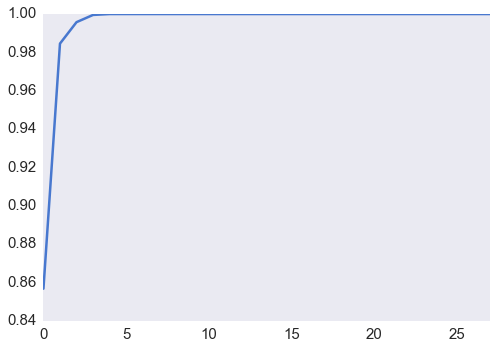

In [111]:
# data
Xsvd = X.copy()
Xsvd.drop(drop_cols, axis=1, inplace=True)

# orig num comps
ncomps = Xsvd.shape[1] - 1

# run svd
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(Xsvd)

# print out variance ranges
for i in range(0, Xsvd.shape[1]-1, 1):
    svar = svd_fit.explained_variance_ratio_.cumsum()[i]
    if svar >= 0.95:
        print('Variance preserved at {:} components == {:.1%}'.format(i, svar))

# plot result        
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line')

At 60 components 98% of variance is preserved, so try keeping just those in a new df.

In [98]:
# transform X
ncomps = 4
X_svd = TruncatedSVD(n_components=ncomps).fit_transform(X)

# save svd to df and add back dropped cols
df_svd = pd.DataFrame(X_svd, columns=['svd{}'.format(c) for c in range(ncomps)], index=df.index)

# save col names for easy filter later
svdcols = [c for c in df_svd.columns if c[:3] == 'svd']

# check size
assert(df_svd.shape[0] == df.shape[0])

In [100]:
df_svd['is_train'] = np.random.uniform(False, True, len(df_svd)) <= 0.3
X_svd_train = 
X_svd_test

(40716, 29)
(40716, 4)


,svd0,svd1,svd2,svd3
0,260.249839,0.740610,493.337727,-180.985846
1,97.839012,-1.970940,340.830035,-149.093792
2,106.380087,-2.712444,329.777569,-145.990369
3,112.361895,-1.728471,354.460670,-150.298124
4,3900.579864,59.762822,3878.367873,-802.341045


#### Linear PCA

In [ ]:
# get rid of the cols that I suspect are not important
X = df_all.copy().drop(drop, 1)

# orig num comps
ncomps = X.shape[1] - 1

# run pca
from sklearn.decomposition import PCA, KernelPCA
pca = PCA(n_components=ncomps, whiten=True)
pca_fit = pca.fit(X)

# plot result        
ax = pd.Series(pca_fit.explained_variance_ratio_.cumsum()).plot(kind='line')

In [ ]:
# transform X
ncomps = 2
X_pca = PCA(n_components=ncomps, whiten=True).fit_transform(X)

# check transform
print "Mean: ", np.round(X_pca.mean(axis=0), decimals=5)
print "Stdv: ", np.round(X_pca.std(axis=0), decimals=5)
print "Corr: ", np.round(np.corrcoef(X_pca.T), decimals=5)

# save pca to df and add back dropped cols
df_pca = pd.DataFrame(X_pca,
                      columns=['pca{}'.format(c) for c in range(ncomps)],
                      index=df_all.index)
for c in drop:
    df_pca[c] = df_all[c]

# save col names for easy filter later
pcacols = [c for c in df_pca.columns if c[:3] == 'pca']

# check size
assert(df_pca.shape[0] == df_all.shape[0])

In [ ]:
g = sns.lmplot('pca0', 'pca1',
               data=df_pca,
               fit_reg=False,
               col="fault_severity")

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_pca', df_pca)
hdf.close()
call(["lrztar", "-zf", hdf_file])

Doesn't look like linearly separable data (as exposed in correlation tasks above). Need to try kernel PCA to remove the nonlinearity.

#### Kernel PCA

In [ ]:
# transform X
X_kpca = KernelPCA(n_components=2, kernel="rbf", gamma=20).fit_transform(X)

In [ ]:
# save pca to df and add back dropped cols
df_kpca = pd.DataFrame(X_kpca,
                       columns=['kpca{}'.format(c) for c in range(ncomps)],
                       index=df_all.index)

for c in drop:
    df_kpca[c] = df_all[c]

# save col names for easy filter later
kpcacols = [c for c in df_kpca.columns if c[:4] == 'kpca']

# check size
assert(df_kpca.shape[0] == df_all.shape[0])

In [ ]:
g = sns.lmplot('kpca0', 'kpca1',
               data=df_kpca,
               fit_reg=False,
               col="fault_severity")

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_kpca', df_kpca)
hdf.close()
call(["lrztar", "-zf", hdf_file])

#### LLE

In [ ]:
from sklearn import manifold
X_lle, err = manifold.locally_linear_embedding(X, n_neighbors=12,
                                             n_components=2)
print("Done. Reconstruction error: %g" % err)

In [ ]:
# save pca to df and add back dropped cols
df_lle = pd.DataFrame(X_lle,
                      columns=['lle{}'.format(c) for c in range(ncomps)],
                      index=df_all.index)
for c in drop:
    df_lle[c] = df_all[c]

# save col names for easy filter later
llecols = [c for c in df_lle.columns if c[:3] == 'lle']

# check size
assert(df_lle.shape[0] == df_all.shape[0])

In [ ]:
g = sns.lmplot('lle0', 'lle1',
               data=df_lle,
               fit_reg=False,
               col="fault_severity")

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_lle', df_lle)
hdf.close()
call(["lrztar", "-zf", hdf_file])

#### t-SNE

Tried SVD and KPCA inputs: SVD outperformed any other. Using it as input to t-SNE

In [ ]:
# build tsne fitter
from sklearn.manifold import TSNE
#metric = metrics.pairwise.manhattan_distances
tsne = TSNE(n_components=2,
            #init='pca',
            perplexity=50,
            #metric=metric,
            learning_rate=500,
            method='barnes_hut',
            verbose=2)

# fit training data only
Z = tsne.fit_transform(df_all)

In [ ]:
# save to df
df_tsne = pd.DataFrame(Z, columns=['x','y'], index=df_all.index)
df_tsne['fault_severity'] = df_all.fault_severity

# check size
assert(df_tsne.shape[0] == df_all.shape[0])

In [ ]:
# kpca
g = sns.lmplot('x', 'y',
               data=df_tsne,
               fit_reg=False,
               col="fault_severity")

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_tsne', df_tsne)
hdf.close()
call(["lrztar", "-zf", hdf_file])

### Clustering

Clustering may be interesting too: could add cluster membership as a new feature. 

* [Binary Jaccard similarity matrix fed into hierarchical cluster and then using the top "nodes"](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html)
* [K-mode/median clustering](https://github.com/nicodv/kmodes)
* [Cosine similarities fed into spectral clustering or dbscan](http://stackoverflow.com/questions/30089675/clustering-cosine-similarity-matrix)
* Frequent itemset mining

#### DBScan

In [ ]:
# remove the log_feature features which are scaled volumes
ecols = [c for c in df_all.columns if 'log_feature' not in c]
X = df_all.copy()[ecols]
X = X[(X.is_train == True)].drop(drop, 1)

In [ ]:
# base similarity matrix
similarity = np.dot(X, X.T)

# squared magnitude of preference vectors (number of occurrences)
square_mag = np.diag(similarity)

# inverse squared magnitude
inv_square_mag = 1 / square_mag

# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0

# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)

# cosine similarity
cosine = similarity * inv_mag
cosine = cosine.T * inv_mag

In [ ]:
# find whole factors for matrix
factors(cosine.shape[0])

In [ ]:
# plot it
binning = 11
plt.figure(figsize=(14, 11))
cmap = sns.light_palette("blue", as_cmap=True)
plt.imshow(cosine[::binning, ::binning], interpolation='none', cmap=cmap)

In [ ]:
# dbscan expects distances, so need 1-cosine input
from sklearn.cluster import DBSCAN
dbclust = DBSCAN(min_samples=30, eps=0.6).fit_predict(1.0-cosine)

In [ ]:
# viz the cluster dist
from collections import Counter
for i in Counter(dbclust).items():
    print i
sns.distplot(dbclust, kde=False)

#### K-modes

In [ ]:
from kmodes import kmodes

# build the clusters
km = kmodes.KModes(n_clusters=22, init='Cao', n_init=5, verbose=1)
clusters = km.fit_predict(X)

# viz the cluster dist
for i in Counter(clusters).items():
    print i
sns.distplot(clusters, kde=False)

That's not a terrible result, it somewhat mimics the tsne result, except for bins 3 and 4, as I don't see any isolated points in tsne, but it's not a 1:1 comparison. Let's see how this performs. First add the cluster assignments to the X matrix.

#### Hierarchical

revisit the correlation measures
run a hierarch model

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster

# create dist matrix
Y = 1.0 - np.abs(df_svd.corr())
Z = linkage(Y, 'complete', 'correlation')

# check cophenetic coeffs; closer to 1, the better
c, coph_dists = cophenet(Z, Y)
print c

# view dendro
dendro = dendrogram(z, labels=Y.columns)
plt.show()

In [ ]:
k = 2
clusters = fcluster(Z, k, criterion='maxclust')
plt.figure(figsize=(14, 11))
plt.scatter(df_svd[:, 0], df_svd[:, 1], c=clusters, cmap='prism')
plt.show()

Check validity of clusters using permutation tests

In [ ]:
# create permutation
svm = SVC(kernel='linear')
cv = StratifiedKFold(y, 2)
score, permutation_scores, pvalue = permutation_test_score(
    svm, X, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=-1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

# histo of permu scores
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

In [ ]:
# append cluster membership to the no-location version of X
a = np.array(clusters)[np.newaxis]
print 'X no loc ', X_nl.shape
X_nlc = np.concatenate((X_nl, a.T), axis=1)
print 'X no loc+clu ', X_nlc.shape

## Learning

### Stacking

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

X = 
y = 

# pca
pca = PCA(n_components=2)

# univariate
selection = SelectKBest(k=1)

# combined estimator
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:
pipeline = Pipeline([("features", combined_features), ("svm", svm)])
param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

# Model Evaluation

## Keras

In [53]:
# quick existing model test
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
thno.config.compute_test_value = 'warn'

In [54]:
# rebuild the train and test sets
xk_train = X_train.as_matrix()
xk_test = X_test.as_matrix()

In [55]:
ohe = preprocessing.LabelBinarizer()
yk_train = ohe.fit_transform(y_train)
yk_test = ohe.fit_transform(y_test)

In [56]:
# common vars
nb_epoch = 20
dims = xk_train.shape[1]
fs = list(factors(dims))
batch_size = fs[-1]/4

In [57]:
# NN model and layers
model = Sequential()
model.add(Dense(512, input_shape=(dims,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

In [59]:
# build model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
# fit the model
model.fit(xk_train, yk_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          show_accuracy=True,
          verbose=1,
          validation_data=(xg_test, yg_test))

Train on 20167 samples, validate on 58970 samples
Epoch 1/20
20167/20167 [==============================] - 43s - loss: 7.4643 - acc: 0.5369 - val_loss: 7.0425 - val_acc: 0.5631
Epoch 2/20
20167/20167 [==============================] - 53s - loss: 7.4632 - acc: 0.5370 - val_loss: 7.0425 - val_acc: 0.5631
Epoch 3/20
20167/20167 [==============================] - 53s - loss: 7.4632 - acc: 0.5370 - val_loss: 7.0425 - val_acc: 0.5631
Epoch 4/20
20167/20167 [==============================] - 54s - loss: 7.4632 - acc: 0.5370 - val_loss: 7.0425 - val_acc: 0.5631
Epoch 5/20
20167/20167 [==============================] - 53s - loss: 7.4632 - acc: 0.5370 - val_loss: 7.0425 - val_acc: 0.5631
Epoch 6/20
 8106/20167 [===========>..................] - ETA: 29s - loss: 7.4108 - acc: 0.5402

KeyboardInterrupt: 

In [63]:
score = model.evaluate(xg_test, yg_test,
                       show_accuracy=True,
                       verbose=0)
print('Loss: {:.2f}'.format(score[0]))
print('Accuracy: {:.2f}'.format(score[1]))

Loss: 0.34
Accuracy: 0.92


In [69]:
# output the highest probability class
pred = model.predict_classes(xg_test)

# check right / wrong
right = np.nonzero(pred == yg_test)[0]
wrong = np.nonzero(pred != yg_test)[0]

32/65 [=============>................] - ETA: 0s

In [22]:
# base data
ids = X_test.index
y_probs = model.predict(xg_test)

final = [[iden, (y_probs[j][0]), (y_probs[j][1]), (y_probs[j][2])] for j, iden in enumerate(ids)]
frame = pd.DataFrame(final,columns=('id','predict_0','predict_1','predict_2'))
frame.head()
#frame.to_csv("keras.csv",index=False)

,id,predict_0,predict_1,predict_2
0,0,1,1.181694e-17,8.876193e-37
1,1,1,2.550678e-15,1.301124e-32
2,2,1,2.951803e-16,6.760162e-34
3,3,1,4.025460e-15,8.693152e-32
4,10,1,1.590513e-18,1.239398e-38


## XGBoost

In [63]:
clf = MyXGBClassifier(n_rounds=100,
                      eta=0.3,
                      max_depth=10,
                      subsample=0.5,
                      colsample_bytree=0.9,
                      booster='gbtree',
                      objective='multi:softprob',
                      num_class=n_classes,
                      eval_metric='mlogloss',
                      silent=0)

param_grid = {'eta': [0.05, 0.3, 0.5],
              'min_child_weight': [0.6, 0.8, 1.0],
              'max_depth': [6, 8, 10],
              'colsample_bytree': [0.3, 0.5],
              'gamma': [0.0, 0.2, 0.4]
             }

gridcv = grid_search.GridSearchCV(clf, param_grid, n_jobs=-1, cv=10)

In [64]:
mtrain = X_train.as_matrix()
mlabels = y_train
gridcv.fit(mtrain, mlabels)

KeyboardInterrupt: 

In [59]:
report(gridcv.grid_scores_, 5)

Model with rank: 1
Mean validation score: 36.259 (std: 26.086)
Parameters: {'eta': 0.5, 'colsample_bytree': 0.5, 'max_depth': 8, 'gamma': 0.0, 'min_child_weight': 0.6}

Model with rank: 2
Mean validation score: 36.259 (std: 26.086)
Parameters: {'eta': 0.5, 'colsample_bytree': 0.5, 'max_depth': 10, 'gamma': 0.0, 'min_child_weight': 0.6}

Model with rank: 3
Mean validation score: 35.984 (std: 25.801)
Parameters: {'eta': 0.5, 'colsample_bytree': 0.5, 'max_depth': 6, 'gamma': 0.0, 'min_child_weight': 0.6}

Model with rank: 4
Mean validation score: 32.463 (std: 24.764)
Parameters: {'eta': 0.3, 'colsample_bytree': 0.5, 'max_depth': 6, 'gamma': 0.0, 'min_child_weight': 0.6}

Model with rank: 5
Mean validation score: 32.463 (std: 24.764)
Parameters: {'eta': 0.3, 'colsample_bytree': 0.5, 'max_depth': 8, 'gamma': 0.0, 'min_child_weight': 0.6}



,colsample_bytree,eta,gamma,max_depth,min_child_weight
0,0.5,0.5,0,8,0.6
1,0.5,0.5,0,10,0.6
2,0.5,0.5,0,6,0.6
3,0.5,0.3,0,6,0.6
4,0.5,0.3,0,8,0.6


### Algorithm Tuning

#### Question: What are the important features in the model?

In [ ]:
# feature importance
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True, random_state=4)
y_pred = y.copy()

# keep values for all features
feat_impt = {}
for f in features:
    feat_impt[f] = []

# go through all features    
for train_index, test_index in kf:
    clf = RF(n_estimators=50, min_samples_split=2, n_jobs=-1)
    X_train, X_test = X.ix[train_index], X.ix[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict(X_test)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        feat_impt[features[indices[f]]].append(importances[indices[f]])

for k in feat_impt:
    val = np.mean(feat_impt[k])
    std = np.std(feat_impt[k])
    feat_impt[k] = val

In [ ]:
# sort the features by importance
sorted_feat = sorted(feat_impt.items(), key=operator.itemgetter(1))
sorted_feat.reverse()

# bookkeeping
cumper = 0.
nbr = False

# make a copy of original dataframe to drop unneeded features
X_keep = X.copy()

# print out importances
print "item -- feature -- weight -- cumm_weight"
for i, k in enumerate(sorted_feat):
    cumper += k[1]
    
    # tell me when we hit 90% of weights
    if (nbr is False and cumper >= 0.95):
        print '**----  Reached 95%  ----**'
        nbr = True
    print i, k[0], '{:.1%}'.format(k[1]), '{:.0%}'.format(cumper)
    
    # drop unneeded features
    if nbr is True:
        X_keep = X_keep.drop(k[0], axis=1)

In [ ]:
features_keep = X_keep.columns

# checks
print "\n%d observations of %d features" % X_keep.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % len(features_keep)

Re-run the ML test harness for RF only and see if the model improves (below is cut and paste of earlier code)

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'n_estimators':72,
                                        'min_samples_split':9,
                                        'n_jobs':-1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X_keep, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))

draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

* RF predictive power got worse when features contributing < 10% weight were dropped.
* **RF predictive power got better when features contributing < 5% weight were dropped.**

#### Question: What model has best calibration and discrimination?

Calibration measures the difference between actual and predicted probability for individual groups. Discrimination measures the difference between model predictions and the baseline probability. Equations are taken from [Yang, Yates, and Smith (1991)](http://psychology.huji.ac.il/.upload/Ilan/YanivYatesSmith1991PB.pdf).

In [ ]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)
    y_prob = np.zeros((len(y), 3))
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train = y[train_index]
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

def calibration(prob, outcome,n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    c = 0.0
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        predicted_prob = np.mean(prob[in_bin])
        true_bin_prob = np.mean(outcome[in_bin])
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob, outcome, n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    d = 0.0
    base_prob = np.mean(outcome)
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [ ]:
print "Lower calibration and higher discrimination are preferred..."

ml_models = []
#ml_models.append(["XGBoost", XGBC, {'max_depth':3, 'n_estimators':300, 'learning_rate':0.05}])
#ml_models.append(["Support Vector Machine", SVC, {}])
ml_models.append(["Linear Logistic Regression", LR, {'multi_class':'multinomial',
                                                     'solver':'lbfgs'}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200,
                                        'min_samples_split':2, 'n_jobs':-1}])

cal_err = []
discrim = []
for m in ml_models:
    print "\n"+m[0]
    pred_prob = run_prob_cv(X, y, m[1], **m[2])
    churn_prob, is_churn = pred_prob[:,1], y == 1
    cal_err.append(calibration(churn_prob, is_churn))
    discrim.append(discrimination(churn_prob,is_churn))
    print '{:20} {:.4f}'.format("Calibration Error", cal_err[-1])
    print '{:20} {:.4f}'.format("Discrimination", discrim[-1])
    
idx, value = min(enumerate(cal_err), key=operator.itemgetter(1))
print '{:20} {:20} {:.3%}'.format('\nBest calibration error:', ml_models[idx][0], cal_err[idx])
idx, value = max(enumerate(discrim), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best discrimination:', ml_models[idx][0], discrim[idx])

#### Question: Can we tune the model params to get better results?

In [ ]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
clf = RF(n_jobs=-1)
param_grid = {"n_estimators":[50, 75, 100],
              "max_depth": [None, 3],
              "max_features": [None, 'auto'],
              "min_samples_split": [4, 9],
              "min_samples_leaf": [1],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
gs = grid_search.GridSearchCV(clf, param_grid=param_grid)
start = time()
gs.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs.grid_scores_)))
report(grid_search.grid_scores_)

**Best scores using X (took 542.40 seconds for 32 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.009)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.955 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}


**Best scores using X_keep (took 471.68 seconds for 48 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'bootstrap': True,
                                        'min_samples_leaf': 1,
                                        'n_estimators': 500,
                                        'min_samples_split': 4,
                                        'criterion': 'entropy',
                                        'max_features': 'auto',
                                        'max_depth': None,
                                        'n_jobs': -1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

**This model is hardly better than the initial guess, but it's technically simpler, so I'll run with this one.**

In [ ]:
# Use 10 estimators so predictions are all multiples of 0.1
m = (["Random Forest", RF, {'bootstrap': True,
                            'min_samples_leaf': 1,
                            'n_estimators': 10,
                            'min_samples_split': 1,
                            'criterion': 'entropy',
                            'max_features': 'auto',
                            'max_depth': None,
                            'n_jobs': -1}])
pred_prob = run_prob_cv(X, y, m[1], **m[2])
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

In [ ]:
from ggplot import *
baseline = np.mean(is_churn)
ggplot(counts, aes(x='pred_prob',y='true_prob',size='count')) + \
        geom_point(color='blue') + \
        stat_function(fun = lambda x: x, color='red') + \
        stat_function(fun = lambda x: baseline, color='green') + \
        xlim(-0.05,  1.05) + \
        ylim(-0.05,1.05) + \
        ggtitle("Random Forest") + \
        xlab("Predicted probability") + ylab("Relative frequency of outcome")

# Final Model

# Scratch